## CS536: Perceptrons
#### Done by - Vedant Choudhary, vc389
In the usual way, we need data that we can fit and analyze using perceptrons. Consider generating data points (X, Y) in the following way:
- For $i = 1,....,k-1$, let $X_i ~ N(0, 1)$ (i.e. each $X_i$ is an i.i.d. standard normal)
- For $i = k$, generate $X_k$ in the following way: let $D ~ Exp(1)$, and for a parameter $\epsilon > 0$ take

$X_k = (\epsilon + D)$ with probability 1/2

$X_k = -(\epsilon + D)$ with probability 1/2

The effect of this is that while $X_1,...X_{k-1}$ are i.i.d. standard normals, $X_k$ is distributed randomly with some gap (of size $2\epsilon$ around $X_k = 0$. We can then classify each point according to the following:

$Y = 1$ with probability 1/2

$Y = -1$ with probability 1/2

We see that the class of each data point is determined entirely by the value of the $X_k$ feature

#### 1. Show that there is a perceptron that correctly classifies this data. Is this perceptron unique? What is the ‘best’ perceptron for this data set, theoretically?

In [7]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm

%matplotlib inline

In [8]:
# Creating X (feature) vectors for the data
def create_data(k, m, D, epsilon):
    X_k_minus_1 = np.random.normal(0, 1, (m,k-1))
    X_k = []
    for i in range(m):
        temp = np.random.choice(2, 1, p=[0.5,0.5])
#         print(temp)
        if temp == 1:
            X_k.append(epsilon + D)
        else:
            X_k.append(-(epsilon + D))
    X_k = np.asarray(X_k).reshape((1,m))
#     print(X_k_minus_1)
#     print(X_k)
    return np.concatenate((X_k_minus_1, X_k.T), axis=1)

# Creating target column for the data
def create_y(X, m):
    y = []
    for i in range(m):
        if X[i][-1] > 0:
            y.append(1)
        else:
            y.append(-1)
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m, epsilon, D):
    X = np.asarray(create_data(k, m, epsilon, D))
    y = np.asarray(create_y(X, m)).reshape((m,1))
    print(X.shape,y.shape)

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+1)]+['Y'])
    return data

In [9]:
# Global Variables - k = 20, m = 100, epsilon = 1
k, m, epsilon = 20, 100, 1
D = float(np.random.exponential(1, 1))

train_data = create_dataset(k, m, epsilon, D)
train_data.head()

(100, 20) (100, 1)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,0.097679,0.048311,-1.408764,-1.115101,-0.577580,-1.160695,0.875647,1.792435,0.353582,-0.772790,...,0.720459,0.514955,0.206826,-0.751163,1.275714,0.270208,-0.903498,-0.232159,-2.164908,-1.0
1,-0.532775,0.823806,1.689542,-0.092628,-1.577128,-0.014022,0.342128,0.122362,0.725618,0.943008,...,-2.094628,0.439961,0.518365,-0.683353,-0.455634,-0.384014,0.203771,-1.723860,2.164908,1.0
2,-1.613375,0.776006,0.204005,1.078115,0.393640,-0.626865,-0.469516,-0.435560,-1.846218,-0.348656,...,1.678369,1.704766,-0.427286,0.760940,-0.168934,-0.116127,-0.576353,-1.736837,2.164908,1.0
3,1.699752,1.465596,-1.045667,0.809284,0.804832,-0.572042,1.406852,-0.603744,0.791317,-0.239988,...,-1.582189,1.135737,0.804935,-0.651315,-0.417393,1.356652,-0.049605,-1.694167,2.164908,1.0
4,0.597461,1.025009,-1.772659,1.385330,1.783041,0.538177,-1.540218,-0.796000,0.296825,-0.082045,...,0.795963,0.073768,0.251828,0.956883,-1.609740,-2.488955,0.888915,2.566588,2.164908,1.0


In [10]:
# Class for Perceptron
class Perceptron():
    def __init__(self):
        pass
    
    def sign_function(self, data_vec):
        return np.array([1 if val >= 1 else -1 for val in data_vec])[:, np.newaxis]
    
    def pla(self, data):
        X = np.asarray(data.iloc[:,:-1])
        y = np.asarray(data.iloc[:,-1:])
        num_samples, num_features = X.shape
#         Initialize weight and bias parameters
        self.w = np.zeros(shape=(num_features, 1))
        self.bias = 0
#         Add check condition if y != f_x ever
        count_till_solution = 0
        while True:
            count_till_solution += 1
#             Calculate the mapping function f(x)
            f_x = self.sign_function(np.dot(X, self.w) + self.bias)
#             Compute weights if f_x != y
            for i in range(num_samples):
                if f_x[i] != y[i]:
                    self.w += np.dot(X[i].T.reshape((num_features, 1)), y[i].reshape((1,1)))
                    self.bias += y[i]
                
            if np.array_equal(y, f_x):
                break
                    
        return self.w, self.bias, count_till_solution
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector, decision tree
    Return - predicted value
    '''
    def predict(self, instance_data):
        prediction = self.sign_function(np.dot(self.w.T, np.asarray(instance_data).reshape((20,1))) + self.bias)
        return prediction   
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i][:-1])
            if prediction != data.iloc[i][-1]:
                error += 1
        return error/len(data) 
        

In [11]:
perceptron = Perceptron()
final_w, final_b, num_steps = perceptron.pla(train_data)
print(final_w)
print(final_b)
print(num_steps)

[[  3.73166689]
 [ -7.80209812]
 [ -1.70273271]
 [  9.9961735 ]
 [ 13.84592798]
 [ -4.09804145]
 [ -6.67398628]
 [ -6.23696107]
 [ 13.72913903]
 [  3.02891677]
 [ -1.62372769]
 [ 18.92262728]
 [ 11.19401271]
 [ -4.46487042]
 [  3.39362407]
 [-11.53594402]
 [ -2.6595887 ]
 [ -2.60073457]
 [  0.6553339 ]
 [110.41029347]]
[51.]
2


In [12]:
error = perceptron.fit(train_data)
error

0.0

In [15]:
test_data = create_dataset(k,m, epsilon,D)
test_error = perceptron.fit(test_data)
test_error

(100, 20) (100, 1)


0.0

#### 3. For any given data set, there may be multiple separators with multiple margins - but for our data set, we can effectively control the size of the margin with the parameter $\epsilon$ - the bigger this value, the bigger the margin of our separator.
#### – For m = 100, k = 20, generate a data set for a given value of $\epsilon$ and run the learning algorithm to completion. Plot, as a function of $\epsilon$ ∈ [0, 1], the average or typical number of steps the algorithm needs to terminate. Characterize the dependence.

In [31]:
def varied_margin():
    k, m = 20, 100
    D = float(np.random.exponential(1, 1))
    epsilon = list(np.arange(0, 1.1, 0.1))
    steps = []
    for i in range(len(epsilon)):
        train_data = create_dataset(k, m, epsilon[i], D)
        perceptron = Perceptron()
        final_w, final_b, num_steps = perceptron.pla(train_data)
        steps.append(num_steps)
        
    plt.plot(epsilon, steps)
    plt.title("Number of steps w.r.t. margin")
    plt.xlabel("Margin value")
    plt.ylabel("#Steps")
    plt.show()

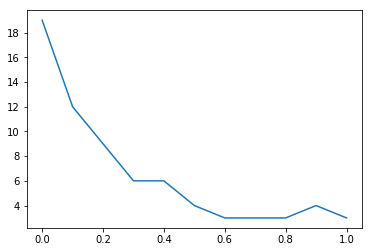

In [34]:
varied_margin()

#### 4. One of the nice properties of the perceptron learning algorithm (and perceptrons generally) is that learning the weight vector w and bias value b is typically independent of the ambient dimension. To see this, consider the following experiment:
#### – Fixing m = 100, $\epsilon$ = 1, consider generating a data set on k features and running the learning algorithm on it. Plot, as a function k (for k = 2, . . . , 40), the typical number of steps to learn a perceptron on a data set of this size. How does the number of steps vary with k? Repeat for m = 1000.

In [35]:
def varied_features(m):
    epsilon = 1
    D = float(np.random.exponential(1, 1))
    k = list(np.arange(2, 40, 1))
    steps = []
    for i in range(len(k)):
        train_data = create_dataset(k[i], m, epsilon, D)
        perceptron = Perceptron()
        final_w, final_b, num_steps = perceptron.pla(train_data)
        steps.append(num_steps)
        
    plt.plot(k, steps)
    plt.title("Number of steps w.r.t. features")
    plt.xlabel("#Features")
    plt.ylabel("#Steps")
    plt.show()

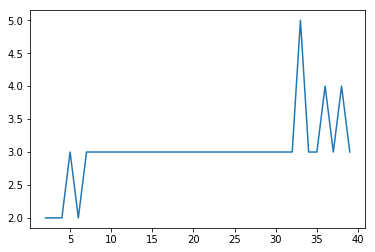

In [36]:
varied_features(100)

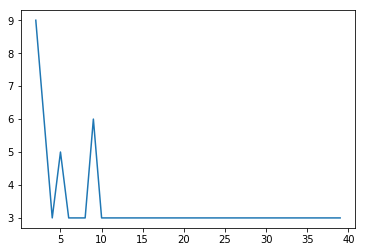

In [37]:
varied_features(1000)

#### 5. As shown in class, the perceptron learning algorithm always terminates in finite time - if there is a separator. Consider generating non-separable data in the following way: generate each $X_1, . . . , X_k$ as i.i.d. standard normals N(0, 1). Define Y by

$$Y = 1 if \sum_{i=1}^k{X_i^2} \ge k $$
$$Y = -1 else$$

In [54]:
def create_non_separable_data(k, m):
    X = np.random.normal(0, 1, (m,k))
    y = []
    for i in range(m):
        total = 0
        for j in range(k):
            total += X[i][j]**2
        
        if total >= k:
            y.append(1)
        else:
            y.append(0)
            
    return X, y

def create_non_separable_dataset(k, m):
    X, y = create_non_separable_data(k, m)
    X = np.asarray(X)
    y = np.asarray(y).reshape((m,1))
    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+1)]+['Y'])
    return data

In [56]:
k, m = 2, 100
train_ns_data = create_non_separable_dataset(k, m)
train_ns_data.head()

,X1,X2,Y
0,0.924559,0.343760,0.0
1,-0.740604,-0.929448,0.0
2,0.019718,-0.829103,0.0
3,-0.028949,-2.225394,1.0
4,1.467515,-0.103812,1.0
